In [1]:
import os
import librosa
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from scipy.stats import skew
import cv2 #pip install opencv-python
from scipy.optimize import minimize
import librosa                    
import librosa.display


import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

#!pip install lightgbm
#import lightgbm as lgbm

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
Initial shape: (288, 432)


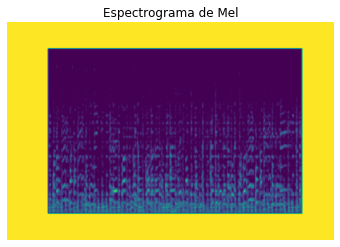

In [2]:
IMG = './data/images_original/'
#IMG = './dataset/'
img_dataset = []
genre_target = []
genres = {}
i = 0
for root, dirs, files in os.walk(IMG):
    for name in files:
        filename = os.path.join(root, name)
        img_dataset.append(filename)
        genre = filename.split('\\')[0].split('/')[-1]
        genre_target.append(genre)
        
        if(genre not in genres):
            genres[genre] = i
            i+=1

print(genres)

img = cv2.imread(img_dataset[0],0)
print("Initial shape:",img.shape)
plt.imshow(img, interpolation = 'bicubic', cmap='viridis')
plt.title("Espectrograma de Mel")
plt.axis('off')
plt.show()

In [3]:
def crop_borders(img,x1=35,x2=252,y1=54,y2=389):
    cropped = img[x1:x2,y1:y2]
    return cropped

def get_y():
    '''Convierte los generos en un array de targets y'''
    y = []
    for genre in genre_target:
        n = genres[genre]
        y.append(n)
    return np.array(y)

def get_x(shape=[999,217*335], flag=0):
    x = np.empty(shape, np.uint8)
    for i in range(len(img_dataset)):
        img = cv2.imread(img_dataset[i],flag)
        img = crop_borders(img)
        #img = crop_borders(img,x1=50,x2=252,y1=54,y2=244)
        x[i] = img.ravel()
    return np.array(x).T

Shape: (217, 335)


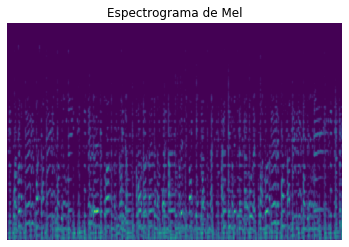

(999, 72695) (999,)


In [4]:
img = cv2.imread(img_dataset[0],0)
img = crop_borders(img)
#img = crop_borders(img,x1=50,x2=252,y1=54,y2=244) #crop to low scale
print("Shape:",img.shape)
plt.imshow(img, interpolation = 'bicubic', cmap='viridis')
plt.title("Espectrograma de Mel")
plt.axis('off')
plt.show()
X = get_x(shape=[999,img.ravel().shape[0]]).T

y = get_y()

m = len(y)
num_labels = 10

print(X.shape, y.shape)

In [5]:
def one_hot(y, m, num_labels):
    '''one hot encoding'''
    y_onehot = np.zeros((m, num_labels))  # 5000 x 10
    for i in range(m):
        y_onehot[i][y[i]] = 1
    return y_onehot

#y_onehot = one_hot(y, m, num_labels)

In [6]:
def extract_features(image_path, vector_size=32):
    image = cv2.imread(image_path, 1)
    image = crop_borders(image)
    try:
        # Using KAZE, cause SIFT, ORB and other was moved to additional module
        # which is adding addtional pain during install
        alg = cv2.KAZE_create()
        # Dinding image keypoints
        kps = alg.detect(image)
        # Getting first 32 of them. 
        # Number of keypoints is varies depend on image size and color pallet
        # Sorting them based on keypoint response value(bigger is better)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        # computing descriptors vector
        kps, dsc = alg.compute(image, kps)
        # Flatten all of them in one big vector - our feature vector
        dsc = dsc.flatten()
        # Making descriptor of same size
        # Descriptor vector size is 64
        needed_size = (vector_size * 64)
        if dsc.size < needed_size:
            # if we have less the 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    except cv2.error as e:
        print ('Error: ', e)
        return None

    return dsc

img_features = extract_features(img_dataset[9])


i = 0
X_KAZE = np.empty([999,img_features.shape[0]], np.float32)
for f in img_dataset:
    if i % 100 == 0:
        print ('Extracting features from image %s' % f)
    #X_KAZE[i] =  extract_features(f)
    i += 1
    
    
X_KAZE.shape

Extracting features from image ./data/images_original/blues\blues00000.png
Extracting features from image ./data/images_original/classical\classical00000.png
Extracting features from image ./data/images_original/country\country00000.png
Extracting features from image ./data/images_original/disco\disco00000.png
Extracting features from image ./data/images_original/hiphop\hiphop00000.png
Extracting features from image ./data/images_original/jazz\jazz00000.png
Extracting features from image ./data/images_original/metal\metal00001.png
Extracting features from image ./data/images_original/pop\pop00001.png
Extracting features from image ./data/images_original/reggae\reggae00001.png
Extracting features from image ./data/images_original/rock\rock00001.png


(999, 2048)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

print(X.shape, X_train.shape, X_test.shape)

(999, 72695) (749, 72695) (250, 72695)


In [8]:
params = {
    "cls__C": [0.5, 1, 2, 5],
    "cls__kernel": ['rbf', 'linear', 'sigmoid'],
}

pipe_svm = Pipeline([
    ('scale', StandardScaler()),
    ('cls', SVC())
])

grid_svm = GridSearchCV(pipe_svm, params, scoring='accuracy', n_jobs=6, cv=5,verbose=50)
grid_svm.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:  4.1min
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:  4.2min
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:  4.3min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  6.0min
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:  6.0min
[Parallel(

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('cls',
                                        SVC(C=1.0, cache_size=200,
                                            class_weight=None, coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='auto_deprecated',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shrinking=True,
                                            tol=0.001, verbose=False))],
                 

In [39]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_sc = scaler.transform(X_train)
clf = sklearn.svm.SVC(kernel='rbf', C=1.0, probability=True)

clf.fit(X_train_sc, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [40]:
preds = clf.predict_proba(X_test)

X_test.shape

(250, 72695)

In [41]:
probpred = preds.argmax(axis=1)
probpred.shape

preds = probpred

In [42]:
preds = grid_svm.predict(X_test)
print("best score on validation set (accuracy) = {:.4f}".format(grid_svm.best_score_))
print("best score on test set (accuracy) = {:.4f}".format(accuracy_score(y_test, preds)))

best score on validation set (accuracy) = 0.4967
best score on test set (accuracy) = 0.5360


In [43]:
cm = confusion_matrix(y_test, preds)
classes = ['metal', 'disco', 'classical', 'hiphop', 'jazz', 'country', 'pop', 'blues', 'reggae', 'rock']

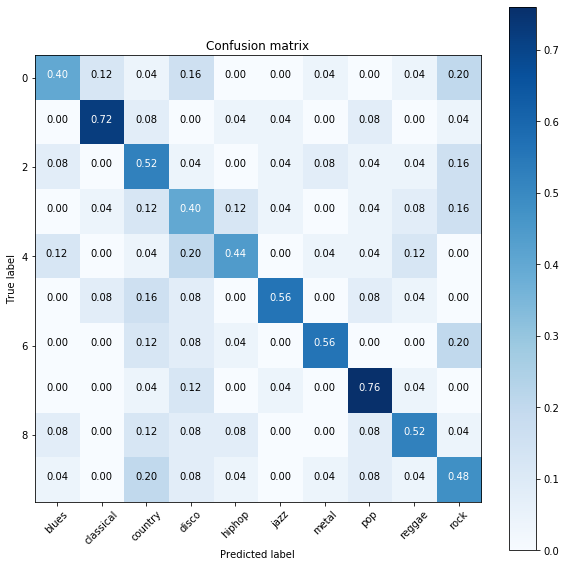

In [44]:

# Helper to plot confusion matrix -- from Scikit-learn website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(genres))
    plt.xticks(tick_marks, genres, rotation=45)
    #plt.yticks(tick_marks, genres)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes, normalize=True)

In [45]:
genres_pred = {}
for k,v in genres.items():
    genres_pred[v] = k
    
genres_pred

files = os.listdir(os.curdir)
songs = [ img for img in files if img.split('.')[-1] == 'png']

In [51]:
for song in songs:
    img = cv2.imread(song,0)
    #img = crop_borders(img)
    #img = crop_borders(img,x1=50,x2=252,y1=144,y2=244)
    #img = extract_features(song)
    mel = img.ravel()
    mel = mel.reshape(1, -1)
    mel = scaler.transform(mel)
    pred = grid_svm.predict(mel.reshape(1, -1))
    pred2 = clf.predict_proba(mel.reshape(1,-1))
    pred = pred2[0].argmax(axis=0)
    print(song)
    print(genres_pred[int(pred)])

abba.png
rock
desakato.png
pop
elfinde.png
hiphop
iseo.png
pop
metallica.png
hiphop
sultans.png
country
